In [1]:
# 학습에 필요한 라이브러리를 불러옵니다.
import os
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import cv2
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
from PIL import Image
from google.colab import drive
import natsort
from sklearn.metrics import mean_squared_error 
import math

In [2]:
# 배치 크기
batch_size = 4

# 이미지의 채널 수로, GRAY 이미지이기 때문에 1 로 설정합니다.
nc = 1

# 학습할 에폭 수
num_epochs = 30

# 옵티마이저의 학습률
lr = 0.0002

# Adam 옵티마이저의 beta 하이퍼파라미터
betas = (0.5, 0.999)

# 학습에 사용될 장치를 선택합니다.
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


In [3]:
# 데이터를 처리할 custom dataset
class Custom_datasets(Dataset):
    def __init__(self,img_path,gt_path,transform=None,img_size=(256,256)):
        self.img = img_path
        self.gt = gt_path
        self.transform = transform
        
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        image = Image.open(self.img[idx])
        gt = Image.open(self.gt[idx])
        
        randomSeed = random.randint(0, 1000)
        random.seed(randomSeed)
        torch.manual_seed(randomSeed)
        image = self.transform(image)
        random.seed(randomSeed)
        torch.manual_seed(randomSeed)
        gt = self.transform(gt)


        return [image, gt]

In [4]:
# Google drive와 github를 연동하기 위한 코드
drive.mount('/content/drive/')                        # Google drive를 mount합니다.
path = '/content/drive/MyDrive/Tutorial_1026/'        # Tutorial_1026 폴더를 만듭니다.
os.makedirs(path,exist_ok=True)
os.chdir(path)
print(os.getcwd())
# github에서 데이터를 다운로드 받습니다.
try:
  !git clone https://github.com/Cheque93/Tutorial_1026.git .
except:
  pass

Mounted at /content/drive/
/content/drive/MyDrive/Tutorial_1026
Cloning into '.'...
remote: Enumerating objects: 326, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 326 (delta 1), reused 0 (delta 0), pack-reused 319
Receiving objects: 100% (326/326), 6.82 MiB | 4.16 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (261/261), done.


In [6]:
# Custom dataset을 구성합니다.
# train/validation/test 셋을 설정합니다.
train_path = path + 'imgs/train/'
train_noise = natsort.natsorted(np.char.add(train_path+'noise/',os.listdir(train_path+'noise')))
train_gt = natsort.natsorted(np.char.add(train_path+'gt/',os.listdir(train_path+'gt')))

valid_path = path + 'imgs/valid/'
valid_noise = natsort.natsorted(np.char.add(valid_path+'noise/',os.listdir(valid_path+'noise')))
valid_gt = natsort.natsorted(np.char.add(valid_path+'gt/',os.listdir(valid_path+'gt')))

test_path = path + 'imgs/test/'
test_noise = natsort.natsorted(np.char.add(test_path+'noise/',os.listdir(test_path+'noise')))
test_gt = natsort.natsorted(np.char.add(test_path+'gt/',os.listdir(test_path+'gt')))

data_transforms = transforms.Compose([  transforms.ToTensor(),
                                        transforms.Normalize((0.5),(0.5))
                                        ])

train_set = Custom_datasets(train_noise,train_gt,data_transforms)
valid_set = Custom_datasets(valid_noise,valid_gt,data_transforms)
test_set = Custom_datasets(test_noise,test_gt,data_transforms)

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
}

In [7]:
# netG와 netD에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# U-net 모델
class Down(nn.Module):                                                                        # Encoding 부분의 Down layer
    def __init__(self, in_channels, out_channels):                                            # 2D MaxPooling과 convolution, batch normalization, PReLU로 구성됩니다.
        super().__init__()                                                                    # Layer를 거치면 사이즈는 1/2로 감소하고 feature는 2배 증가합니다.
        self.conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
            )

    def forward(self, x):
        return self.conv(x)
    
class Up(nn.Module):                                                                          # Decoding 부분의 Up layer
    def __init__(self, in_channels, out_channels):                                            # 2D transposed convolution과 batch normalization, PReLU로 구성됩니다.
        super().__init__()                                                                    # Layer를 거치면 사이즈는 2배 증가하고 feature는 1/2로 감소합니다.
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
            )
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW                    
        diffY = x2.size()[2] - x1.size()[2]                                                   # UNet의 skip-connection을 위해 padding을 통해 사이즈를 조정합니다.
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class UNet(nn.Module):                                                                        # 앞서 작성한 down 및 up layer를 사용한 UNet 모델
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.n_channels = n_channels                                                          # Input image의 channel
        self.inc = nn.Conv2d(n_channels, ngf,kernel_size=3, padding=1)                        # Init convolution
        self.down1 = Down(ngf, ngf*2)                                                         # Down layer를 통해 사이즈는 1/2로 감소하고 feature는 2배 증가합니다.
        self.down2 = Down(ngf*2, ngf*4)
        self.up1 = Up(ngf*4, ngf*2)                                                           # Up layer를 통해 사이즈는 2배 증가하고 feature는 1/2로 감소합니다.
        self.up2 = Up(ngf*2, ngf)
        self.out_conv = nn.Conv2d(ngf, n_channels, kernel_size=1)                             # channel 크기를 맞추기 위한 out convolution

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        logits =  self.out_conv(x)
        
        return logits

In [10]:
# 모델 구성 부분
# 앞서 구성한 Denoising Unet을 생성하고 초기화 합니다.
DNnet = UNet(n_channels = nc).to(device)
DNnet.apply(weights_init)

UNet(
  (inc): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): Down(
    (conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): PReLU(num_parameters=1)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): PReLU(num_parameters=1)
    )
  )
  (up1): Up(
    (up): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (conv): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=

In [11]:
# BCELoss 함수의 인스턴스를 생성합니다
criterion = torch.nn.MSELoss()
# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다

# 학습에서 사용할 Adam옵티마이저를 생성합니다
optimizer = torch.optim.Adam(DNnet.parameters(), lr=lr, betas=betas)

In [14]:
# 모델 학습 부분
Tr_losses = np.zeros((num_epochs))                                              # Loss를 저장할 변수를 선언합니다.
Val_losses = np.zeros((num_epochs))

best_loss = 1e5                                                                 # best loss 저장을 위한 변수


print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내 train 과 valid 페이즈를 나누어 
    # train 페이즈에만 파라미터 업데이트하도록 설정합니다
    for phase in ['train','valid']:
        if phase=='train':
            DNnet.train()
        else:
            DNnet.eval()
        for i, data in enumerate(dataloaders[phase]):
            # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
            inputs = data[0].to(device)
            labels = data[1].to(device)
            # 기울기를 초기화 합니다.
            optimizer.zero_grad()

            # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
            denoised_imgs = DNnet(inputs)
            #손실값을 계산합니다.
            loss = criterion(denoised_imgs, labels)

            # 역전파를 실시한 후 손실값을 저장합니다.
            if phase == 'train':
                loss.backward()
                optimizer.step()
                Tr_losses[epoch] += loss.data.item()
            else:
                Val_losses[epoch] += loss.data.item()
                
            # train상태의 손실값을 출력합니다.
            if phase=='train':
                print('\rtrain: [%d/%d][%d/%d]\tLoss: %.4f'
                      % (epoch+1, num_epochs, i+1, len(dataloaders['train']),
                         Tr_losses[epoch]/(i+1)),end='')
        # 훈련을 한 에폭 마친 후 train 손실 값을 평균 내어 저장합니다.     
        if phase=='train':
            Tr_losses[epoch] = Tr_losses[epoch]/(i+1)
            
        # 훈련을 한 에폭 마친 후 valid 손실 값을 평균 내어 저장 및 출력합니다..   
        if phase=='valid':
            Val_losses[epoch] = Val_losses[epoch]/(i+1)  
            print('\rvalid: [%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch+1, num_epochs, i+1, len(dataloaders['valid']),
                     Val_losses[epoch]),end='')
            if Val_losses[epoch] < best_loss:
                print("\nsaving best model with %.4f loss"%(Val_losses[epoch]),end='')
                best_loss = Val_losses[epoch]
                best_model_wts = copy.deepcopy(DNnet.state_dict())

        print()


Starting Training Loop...
train: [1/30][25/25]	Loss: 0.4416
valid: [1/30][4/4]	Loss_D: 0.5046
saving best model with 0.5046 loss

train: [2/30][25/25]	Loss: 0.2653
valid: [2/30][4/4]	Loss_D: 0.1887
saving best model with 0.1887 loss

train: [3/30][25/25]	Loss: 0.1701
valid: [3/30][4/4]	Loss_D: 0.0412
saving best model with 0.0412 loss

train: [4/30][25/25]	Loss: 0.1047
valid: [4/30][4/4]	Loss_D: 0.0285
saving best model with 0.0285 loss

train: [5/30][25/25]	Loss: 0.0621
valid: [5/30][4/4]	Loss_D: 0.0272
saving best model with 0.0272 loss

train: [6/30][25/25]	Loss: 0.0347
valid: [6/30][4/4]	Loss_D: 0.0124
saving best model with 0.0124 loss

train: [7/30][25/25]	Loss: 0.0194
valid: [7/30][4/4]	Loss_D: 0.0096
saving best model with 0.0096 loss

train: [8/30][25/25]	Loss: 0.0107
valid: [8/30][4/4]	Loss_D: 0.0140
train: [9/30][25/25]	Loss: 0.0067
valid: [9/30][4/4]	Loss_D: 0.0073
saving best model with 0.0073 loss

train: [10/30][25/25]	Loss: 0.0044
valid: [10/30][4/4]	Loss_D: 0.0133
trai

In [15]:
# 저장한 best weight를 불러옵니다.
DNnet.load_state_dict(best_model_wts)

<All keys matched successfully>

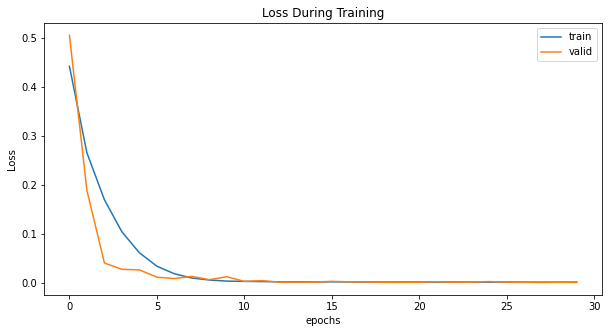

In [18]:
#학습과정의 loss를 출력합니다.
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(Tr_losses,label="train")
plt.plot(Val_losses,label="valid")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
# test셋에서 검증합니다.
DNnet.eval()
tb = iter(dataloaders['test'])

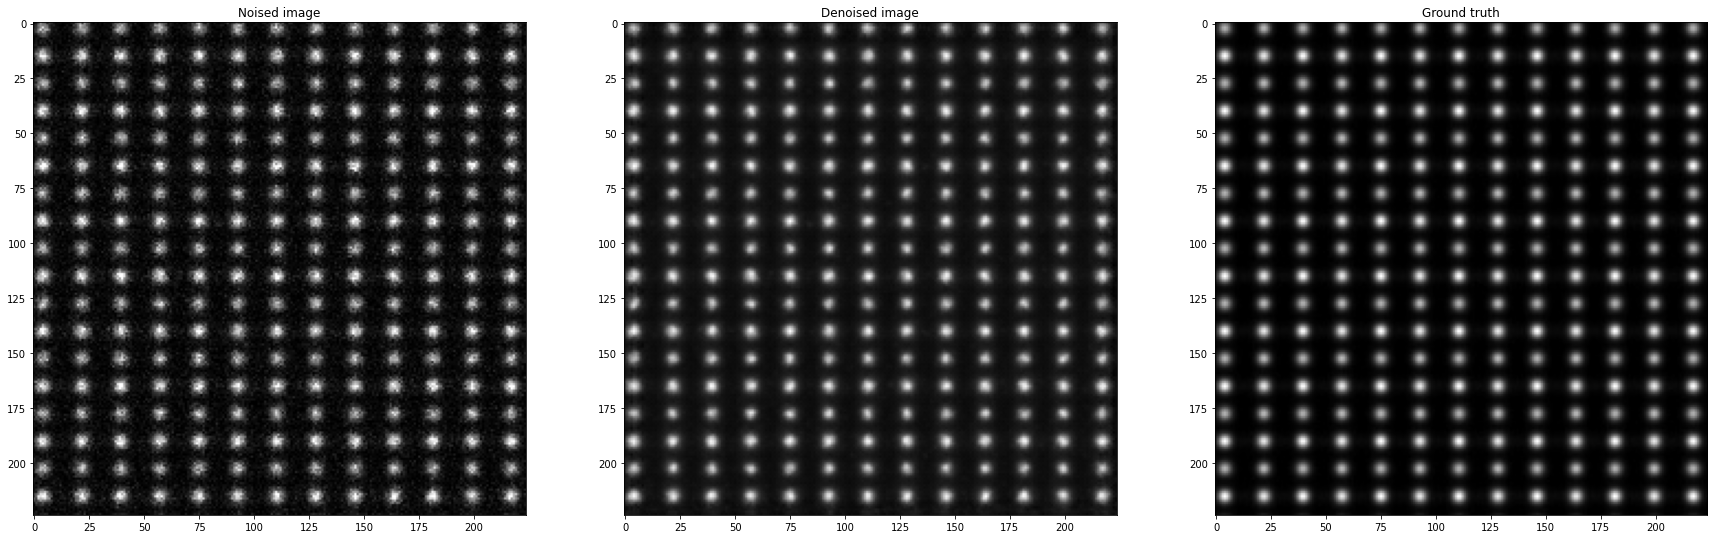

0.0008380796


In [20]:
# test셋에서 데이터를 불러옵니다.
test_batch = next(tb)
t_noise = test_batch[0].to(device)
t_img = test_batch[0].cpu().detach().numpy()[0].transpose((1,2,0))
t_gt = test_batch[1].cpu().detach().numpy()[0].transpose((1,2,0))
# 학습된 모델로 noise 이미지를 denoising 합니다.
test_result = DNnet(t_noise)
test_result = test_result.cpu().detach().numpy()[0].transpose((1,2,0))
# 정규화
test_result = (test_result+1)*0.5
t_gt = (t_gt+1)*0.5
t_img = (t_img+1)*0.5
# 결과를 출력합니다.
fig, ax = plt.subplots(1,3,figsize=(30,30))
ax[0].set_title('Noised image')
ax[0].imshow(t_img[:,:,0],cmap='gray')
ax[1].set_title('Denoised image')
ax[1].imshow(test_result[:,:,0],cmap='gray')
ax[2].set_title('Ground truth')
ax[2].imshow(t_gt[:,:,0],cmap='gray')
plt.show()

# mean squared error를 계산합니다.
mse = mean_squared_error(t_gt[:,:,0],test_result[:,:,0])
print(mse)


In [21]:
# psnr을 계산하기 위한 함수
def calc_psnr(truth,compare,pixel_max=255.0):
    mse = np.mean((truth-compare)**2)
    if mse == 0:
        return 100
    return 20*math.log10(pixel_max/math.sqrt(mse))


In [22]:
# 전체 test셋에 대해 pnsr과 mse를 계산합니다.
tb = iter(dataloaders['test'])
total_mse = []
total_psnr = []
for test_batch in tb:
    t_noise = test_batch[0].cuda()
    t_img = test_batch[0].cpu().detach().numpy()[0].transpose((1,2,0))
    t_gt = test_batch[1].cpu().detach().numpy()[0].transpose((1,2,0))
    test_result = DNnet(t_noise).cpu().detach().numpy()[0]
    test_result = test_result.transpose((1,2,0))
    test_result = (test_result+1)*127.5
    t_gt = (t_gt+1)*127.5
    t_img = (t_img+1)*127.5
    mse = mean_squared_error(t_gt[:,:,0]/255,test_result[:,:,0]/255)
    p = calc_psnr(t_gt[:,:,0],test_result[:,:,0])
    total_mse.append(mse)
    total_psnr.append(p)
# 평균 mse와 pnsr을 계산합니다.
print(np.mean(total_mse))
print(np.mean(total_psnr))


0.00067723886
31.76850097154854
